### 1. 모델 구현
### 2. 데이터 클래스
### 3. 데이터 로더
### 4. 손실함수
### 5. optimizer
### 6. weight 저장후, inference
### 7. 평가지표로 평가

In [2]:
### 1. 모델 구현 OK
# 직사각형 input, 직사각형 output 되도록 kernel사이즈나 그런것들 조절해주기
### 2. 데이터 클래스 @
#  run length encoded된거 decode하기 @
### 3. 데이터 로더 @
### 4. Transformer, collate_fn 구현 -----> Proceeding...
# 데이터 클래스 이전에 구현해서 데이터 인스턴스에 넣어주기
### 5. 손실함수
### 6. optimizer
### 7. weight 저장후, inference
### 8. 평가지표로 평가

In [14]:
!pip freeze > requirements.txt

In [13]:
!conda activate unet

In [7]:
import numpy as np
import torch
import torchvision
import os
import cv2
import torch.nn as nn
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt
import collections
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [8]:
BATCH_SIZE = 8
LEARNING_RATE = 1e-3
EPOCHS = 20
NUM_CLASSES = 2

In [9]:
# 1.모델구현
class Unet(nn.Module):
  def __init__(self):
    super().__init__()
    self.ConPathLayer1 = nn.Sequential(
        torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(1,3), stride=1, padding=(25,0), padding_mode='reflect', dilation=(1,67)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.MaxPool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.ConPathLayer2 = nn.Sequential(
        torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.MaxPool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.ConPathLayer3 = nn.Sequential(
        torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.MaxPool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.ConPathLayer4 = nn.Sequential(
        torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.MaxPool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.BottomLayer = nn.Sequential(
        torch.nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.UpConv1 = torch.nn.ConvTranspose2d(in_channels=1024, out_channels=512,kernel_size=2 , stride=2 )

    self.ExpPathLayer1 = nn.Sequential(
        torch.nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.UpConv2 = torch.nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=2 , stride=2 )

    self.ExpPathLayer2 = nn.Sequential(
        torch.nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.UpConv3 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=2 , stride=2 )

    self.ExpPathLayer3 = nn.Sequential(
        torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
        torch.nn.ReLU()
    )

    self.UpConv4 = torch.nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size=2 , stride=2 )

    self.ExpPathLayer4 = nn.Sequential(
        torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=64, out_channels=2, kernel_size=(1,1), stride=1, padding=(66,158), padding_mode='replicate', dilation=(1,1))
    )

  def forward(self, x):
    x = self.ConPathLayer1(x)
    skip1 = torchvision.transforms.CenterCrop(392)(x)
    x = self.MaxPool1(x)
    x = self.ConPathLayer2(x)
    skip2 = torchvision.transforms.CenterCrop(200)(x)
    x = self.MaxPool2(x)
    x = self.ConPathLayer3(x)
    skip3 = torchvision.transforms.CenterCrop(104)(x)
    x = self.MaxPool3(x)
    x = self.ConPathLayer4(x)
    skip4 = torchvision.transforms.CenterCrop(56)(x)
    x = self.MaxPool4(x)
    # print("skip1:{}, skip2:{}, skip3:{}, skip4:{}".format(skip1.shape, skip2.shape, skip3.shape, skip4.shape))
    x = self.BottomLayer(x)
    x = self.UpConv1(x)
    x = torch.cat((skip4, x), dim=1)
    x = self.ExpPathLayer1(x)
    x = self.UpConv2(x)
    x = torch.cat((skip3, x), dim=1)
    x = self.ExpPathLayer2(x)
    x = self.UpConv3(x)
    x = torch.cat((skip2, x), dim=1)
    x = self.ExpPathLayer3(x)
    x = self.UpConv4(x)
    x = torch.cat((skip1, x), dim=1)
    result = self.ExpPathLayer4(x)

    return result



In [4]:
input = np.random.randn(1, 3, 520, 704)
input = torch.tensor(input).float()

In [5]:
model = Unet()
prediction = model(input)
print(prediction.shape)

torch.Size([1, 2, 520, 704])


In [6]:
prediction.shape

torch.Size([1, 2, 520, 704])

In [7]:
predictions_ = torch.argmax(prediction, dim=1) 
predictions_

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]])

In [8]:
predictions_.shape

torch.Size([1, 520, 704])

In [9]:
onehot_pred = F.one_hot(predictions_,num_classes=NUM_CLASSES)
onehot_pred.shape

torch.Size([1, 520, 704, 2])

In [10]:
onehot_pred = onehot_pred.permute(0,3,1,2)
onehot_pred.shape

torch.Size([1, 2, 520, 704])

In [11]:
np.unique(onehot_pred[:,0,:,:])

array([0, 1], dtype=int64)

(2, 520, 704)
[[0.03974522 0.03974522 0.03974522 ... 0.05690077 0.05690077 0.05690077]
 [0.03974522 0.03974522 0.03974522 ... 0.05690077 0.05690077 0.05690077]
 [0.03974522 0.03974522 0.03974522 ... 0.05690077 0.05690077 0.05690077]
 ...
 [0.04121641 0.04121641 0.04121641 ... 0.03848826 0.03848826 0.03848826]
 [0.04121641 0.04121641 0.04121641 ... 0.03848826 0.03848826 0.03848826]
 [0.04121641 0.04121641 0.04121641 ... 0.03848826 0.03848826 0.03848826]]


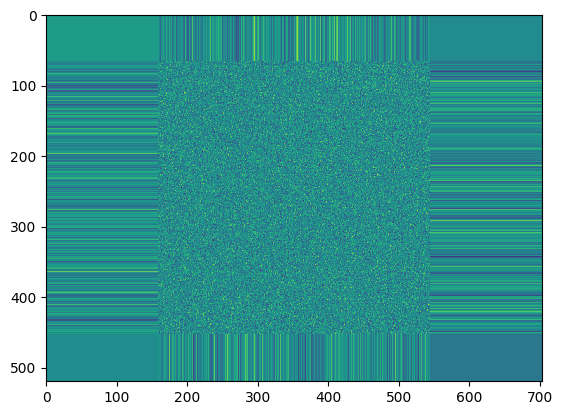

In [13]:
pred= prediction.detach().numpy()
pred1 = pred[0,:,:,:]
print(pred1.shape)
print(pred1[1,:,:])
plt.imshow(pred1[0,:,:], interpolation='nearest')
plt.show()
# Image.fromarray(pred1[0,:,:])

In [14]:
summary(model, (3, 520, 704), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 570, 570]             640
              ReLU-2          [8, 64, 570, 570]               0
            Conv2d-3          [8, 64, 568, 568]          36,928
              ReLU-4          [8, 64, 568, 568]               0
         MaxPool2d-5          [8, 64, 284, 284]               0
            Conv2d-6         [8, 128, 282, 282]          73,856
              ReLU-7         [8, 128, 282, 282]               0
            Conv2d-8         [8, 128, 280, 280]         147,584
              ReLU-9         [8, 128, 280, 280]               0
        MaxPool2d-10         [8, 128, 140, 140]               0
           Conv2d-11         [8, 256, 138, 138]         295,168
             ReLU-12         [8, 256, 138, 138]               0
           Conv2d-13         [8, 256, 136, 136]         590,080
             ReLU-14         [8, 256, 1

In [ ]:
# 2. 데이터 클래스 정의 

In [13]:
#실험
# train_path = "/content/drive/MyDrive/Paper Implementation/Unet/dataset/train"
train_path = "C:/Users/syb62/Desktop/Unet/train"
train_list = os.listdir(train_path)
train_img_list=[]
for i in train_list:
  if i.endswith(".png"):
    train_img_list.append(i)

len(train_img_list)

606

In [16]:
#실험
# train_csv_path = "/content/drive/MyDrive/Paper Implementation/Unet/dataset/train/train.csv"
train_csv_path = "C:/Users/syb62/Desktop/Unet/train.csv/train.csv"
train_df = pd.read_csv(train_csv_path)
test=[]
df_ids = np.array(train_df.loc[:, "id"].values).tolist()
mask_dic = {}

for img_name in train_img_list:
  id = img_name.split(".")[0]
  test=[]
  for j in range(len(df_ids)):
    if df_ids[j] == id:
      a = train_df.loc[:, "annotation"].values[j]
      test.append(a)
    else:
      pass
  mask_dic[id]=test


In [17]:
#실험
image_info = collections.defaultdict(dict)
for i in range(len(mask_dic.keys())):
            mask_dic_keys = list(mask_dic.keys())
            image_info[i]={
                    'image_id': mask_dic_keys[i],
                    'image_path': os.path.join(train_path, mask_dic_keys[i] + '.png'),
                    'annotations': mask_dic[mask_dic_keys[i]]
                    }

In [205]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [206]:
#실험
idx=0
info = image_info[idx]
img_path = info["image_path"]
img = cv2.imread(img_path)

HEIGHT = 520
WIDTH = 704
height = HEIGHT
width = WIDTH

masks = np.zeros((len(info['annotations']), height, width), dtype=np.uint8)
boxes = []
labels=[]

for i, annotation in enumerate(info['annotations']):
    a_mask = rle_decode(annotation, (HEIGHT, WIDTH))
    a_mask = Image.fromarray(a_mask)
    
    # if self.should_resize:
    if True:
        a_mask = a_mask.resize((width, height), resample=Image.BILINEAR)
        a_mask = np.array(a_mask) > 0
        labels.append(a_mask)
        masks[i, :, :] = a_mask
        # boxes.append(get_box(a_mask))
# print(img)
# cv2.imshow('Original', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [208]:
len(labels)

395

(520, 704)


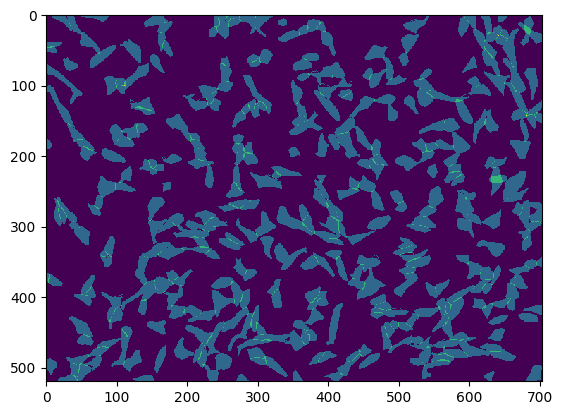

In [77]:
# 실험
total = np.zeros((520, 704))
for i in range(len(labels)):
    total = total + labels[i]
    
print(total.shape)
plt.imshow(total, interpolation='nearest')
plt.show()

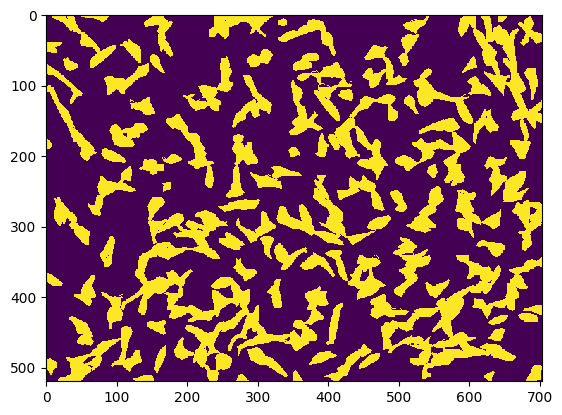

In [86]:
# 실험
total= (total>=1)
plt.imshow(total, interpolation='nearest')
plt.show()

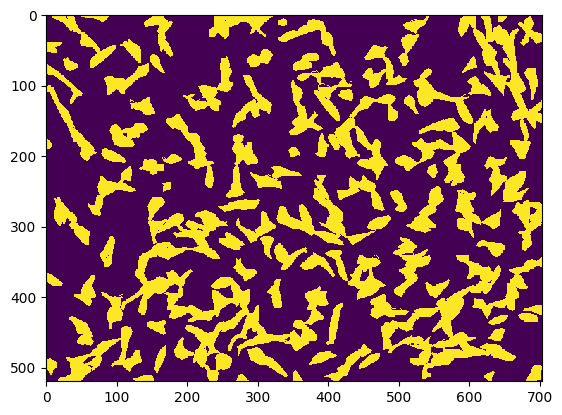

In [88]:
# 실험
total = total.reshape(((520, 704, 1)))
plt.imshow(total, interpolation='nearest')
plt.show()

In [4]:
# Real
class CT_Dataset():
    def __init__(self, phase, transformer=None):
        # self.train_csv_path = "/content/drive/MyDrive/Paper Implementation/Unet/dataset/train/train.csv"
        # self.train_path = "/content/drive/MyDrive/Paper Implementation/Unet/dataset/train"
        self.train_csv_path = "C:/Users/syb62/Desktop/Unet/train/train.csv"
        self.train_path = "C:/Users/syb62/Desktop/Unet/train"
        
        self.phase = phase
        self.train_img_list = [] # train 이미지들 목록
        self.image_info = collections.defaultdict(dict) # train이미지 id, 이미지 경로, 라벨(annotation)
        self.transformer = transformer
        
        ################ train이미지 목록 리스트 생성 ################
        train_list = os.listdir(self.train_path)
        for i in train_list:
          if i.endswith(".png"):
            self.train_img_list.append(i)

        ################ image_info 생성 ################
        train_df = pd.read_csv(self.train_csv_path)
        anno_list=[]
        df_ids = np.array(train_df.loc[:, "id"].values).tolist()
        mask_dic = {}

        for img_name in self.train_img_list:
          id = img_name.split(".")[0]
          anno_list=[]
          for j in range(len(df_ids)):
            if df_ids[j] == id:
              a = train_df.loc[:, "annotation"].values[j]
              anno_list.append(a)
            else:
              pass
          mask_dic[id]=anno_list

          for i in range(len(mask_dic.keys())):
            mask_dic_keys = list(mask_dic.keys())
            self.image_info[i]={
                    'image_id': mask_dic_keys[i],
                    'image_path': os.path.join(self.train_path, mask_dic_keys[i] + '.png'),
                    'annotations': mask_dic[mask_dic_keys[i]]
                    }

    def __len__(self,):
        return len(self.train_img_list)
    
    def rle_decode(self, mask_rle, shape, color=1):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, 1 - mask, 0 - background
        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
        for lo, hi in zip(starts, ends):
            img[lo : hi] = color
        return img.reshape(shape)

    def __getitem__(self, idx):

        info = self.image_info[idx]
        img_path = info["image_path"]
        image = cv2.imread(img_path)
        
        ##########################

        HEIGHT = 520
        WIDTH = 704
        # HEIGHT = 388
        # WIDTH = 388
        height = HEIGHT
        width = WIDTH

        masks = np.zeros((len(info['annotations']), height, width), dtype=np.uint8)
        labels=[]

        for i, annotation in enumerate(info['annotations']):
            a_mask = self.rle_decode(annotation, (HEIGHT, WIDTH))
            a_mask = Image.fromarray(a_mask)

            # if self.should_resize:
            if True:
                a_mask = a_mask.resize((width, height), resample=Image.BILINEAR)
                a_mask = np.array(a_mask) > 0
                labels.append(a_mask)
                masks[i, :, :] = a_mask
        ##########################
        total = np.zeros((520, 704))
        # total = np.zeros((388, 388))
        for i in range(len(labels)):
            total = total + labels[i]
        
        total= (total>=1)
        # total = total.reshape(((1, 520, 704)))
        target = total
        
        if self.transformer:
            image = self.transformer(image)
        
        target = torch.from_numpy(target).long()
        
        return image, target


In [5]:
### 3. Transformer & collate_fn 구현
transformer = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize(size=(572,572)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    
])

In [6]:
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch: 
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0) 
    targets = torch.stack(targets, dim=0)

    return images, targets

In [18]:
plt.imshow(onehot_target[0,0,:,:], interpolation='nearest')
plt.show()

NameError: name 'onehot_target' is not defined

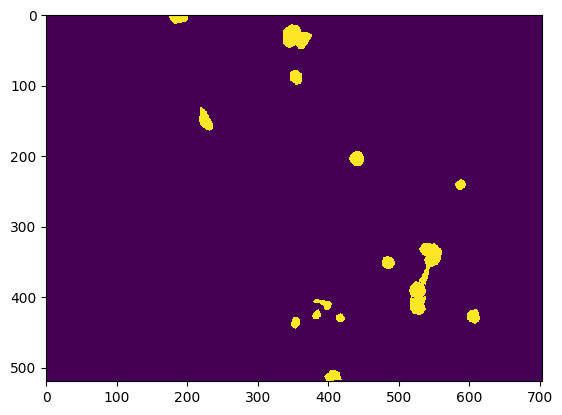

In [25]:
plt.imshow(onehot_target[0,1,:,:], interpolation='nearest')
plt.show()

In [ ]:
### 4. 데이터 로더

In [19]:
train_data = CT_Dataset(phase='train', transformer=transformer)
data, target = train_data[605]

In [20]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn,shuffle=True)

In [ ]:
# def build_dataloader(data_dir, batch_size=BATCH_SIZE):
#     transformer = build_transformer()
    
#     dataloaders = {}
#     train_dataset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)
#     dataloaders["train"] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

#     val_dataset = CT_dataset(data_dir=data_dir, phase="val", transformer=transformer)
#     dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
#     return dataloaders

In [7]:
### 5. 손실함수 계산 Class 선언
class Unet_loss():
    def __init__(self, num_classes):
        self.num_classes=num_classes
        self.CE_loss = nn.CrossEntropyLoss(reduction="mean")
        # [B, 2, 520, 704] 크기의 prediction입력
        # self.prediction=prediction
        # [B, 520, 704] 크기의 target입력
        # self.target=target
    def __call__(self, prediction, target):
        loss = self.get_loss(prediction, target)
        return loss
    
    def get_loss(self,  prediction, target):
        ################ Dice Coefficient 적용할거면 연산 진행해서 넣어주기 ################
        # prediction: [B, 2, 520, 704] -> [B, 2, 520, 704] 예측한 label값으로 변환
        predictions_ = torch.argmax(prediction, dim=1)
        onehot_pred = F.one_hot(predictions_,num_classes=self.num_classes)
        onehot_pred = onehot_pred.permute(0,3,1,2)
        
        # prediction: [B, 520, 704] -> [B, 2, 520, 704] 을 예측한 label값으로 변환
        onehot_target = F.one_hot(target , num_classes=self.num_classes).permute(0,3,1,2)
        ########################################################################################
        
        # CE loss 계산
        # ce_loss = self.CE_loss(onehot_pred, onehot_target)
        ce_loss = self.CE_loss(prediction, target)
        
        return ce_loss
        

In [22]:
criterion = Unet_loss(num_classes=NUM_CLASSES)
# criterion(output,target_batch)

In [24]:
### 6. optimizer
optimizer = torch.optim.SGD(model.parameters(), lr= LEARNING_RATE, momentum=0.9)

In [26]:
### 7. Training
# for idx, batch in enumerate(trainloader):
#     train_batch_data = batch[0]
#     target_batch = batch[1]
#     output = model(train_batch_data)
#     loss = criterion(output,target_batch)
#     print(f"idx:{idx}, batch image: {train_batch_data.shape}, \
#     batch target:{target_batch.shape}, output: {output.shape}, loss: {loss}")

In [8]:
def train_one_epoch(trainloader, model,optimizer,criterion,device):
    losses = {}
    # for phase in ['train', 'val']:
    for phase in ['train']:
        running_loss = 0.0

        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        for idx, batch in enumerate(trainloader):
            train_batch_data = batch[0].to(device)
            target_batch = batch[1].to(device)
            
            with torch.set_grad_enabled(phase=='train'):
                pred = model(train_batch_data)
                loss = criterion(output,target_batch)
            
            if phase == 'train':
                optimizer.zero_grad() 
                # optimizer의 갱신할 기울기 값을, 즉, 연결되어있는 모든 model params의 기울기값들을 초기화
                loss.backward()
                optimizer.step()
            
            running_loss = loss.item()
            
            if phase == "train":
                if index % 5 == 0:
                    text = f"{index}/{len(trainloader)}" + \
                            f" - Running Loss: {loss.item():.4f}"
                    print(text)
            
        losses[phase] = running_loss / len(trainloader)
                    
    # print(f"idx:{idx}, batch image: {train_batch_data.shape}, \
    # batch target:{target_batch.shape}, output: {pred.shape}, loss: {loss}")
    return losses

In [ ]:
for idx, batch in enumerate(trainloader):
            train_batch_data = batch[0].to(device)
            target_batch = batch[1].to(device)

In [42]:
len(trainloader)

76

In [9]:
def save_model(model_state, model_name, save_dir="C:/Users/syb62/Desktop/Unet"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [11]:
is_cuda = False
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')
# DEVICE = torch.device('cpu')

BATCH_SIZE = 8
LEARNING_RATE = 1e-3
EPOCHS = 20
NUM_CLASSES = 2

train_data = CT_Dataset(phase='train', transformer=transformer)
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn,shuffle=True)
model = Unet()
model = model.to(DEVICE)
criterion = Unet_loss(num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr= LEARNING_RATE, momentum=0.9)

In [45]:
num_epochs = EPOCHS

best_epoch = 0
best_score = 0.0
train_loss = []
# val_loss, val_dice_coefficient = [], []

for epoch in range(num_epochs):
    losses = train_one_epoch(trainloader, model, optimizer, criterion, DEVICE)
    train_loss.append(losses["train"])
    # val_loss.append(losses["val"])
    
    print(f"{epoch}/{num_epochs} - Train Loss: {losses['train']:.4f}")
    
    if (epoch > 3) and (dice_coefficients["val"] > best_score):
        best_epoch = epoch
        # best_score = dice_coefficients["val"]
        save_model(model.state_dict(), f"model_{epoch:02d}.pth")
        
print(f"Best epoch: {best_epoch} -> Best Dice Coeffient: {best_score:.4f}")

TypeError: pic should be PIL Image or ndarray. Got <class 'NoneType'>

In [ ]:
### 8. weight 저장후, inference

In [ ]:
### 9. 평가지표로 평가